In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState

## 背景介绍

假设我们现在存在一个商品预测的问题：已知商品的成本 $1$ 元, 利润 $10$ 元，如何根据商家以往的销售数据预测商品的销量。

## 搜集数据/数据准备

假设每天的销量与两个特征有关 $x_1, x_2$, 随机产生 $128$ 组特征数据 和 $128$ 个销量数据。其中在产生销量数据时，假如了噪音 `rdm.randon()/10 - 0.05`，噪音范围限制在 $[-0.05, +0.05]$之间。

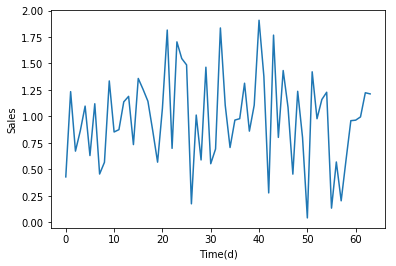

In [14]:
rdm = RandomState(1)
M = 64
Batch_Size = 16
train_X = rdm.rand(2, M) # shape:[2, m]
train_Y = [[x1+x2+(rdm.rand()/10.0-0.05)] for (x1, x2) in train_X.T]
train_Y = np.array(train_Y).reshape(1, -1)

plt.plot(np.arange(M), train_Y[0, :])
plt.xlabel("Time(d)")
plt.ylabel("Sales")
plt.show()

## 定义神经网络相关参数

神经网路模型定义为两层全连接层网络。每层节点个数为: $[2， 1]$.

In [15]:
Place_X = tf.placeholder(tf.float32, shape=(2, None), name='X-input')
Place_Y = tf.placeholder(tf.float32, shape=(1, None), name="Y-input")
W1 = tf.Variable(np.random.rand(1, 2) * np.sqrt(2.0), dtype=tf.float32)
B1 = tf.zeros(shape=[1, 1])
Z1 = tf.matmul(W1, Place_X) + B1

## 设置自定义的损失函数

通常我们可能会使用最小化 MSE (均方误差),那么此模型很有可能无法实现最大化预期的利润：因为成本$1$, 利润$10$, 那么少预测一个就要少挣 $10$ 元, 多预测一个才少挣 $1$ 元。为了最大化预期的利润，我们需要将损失函数和利润直接联系起来。注意损失函数定义的是损失(即少赚了多少钱)，所以要将利润最大化，定义的损失函数应该是刻画损失。定义的损失函数如下:

$$
J = \sum_{i=1}^{m}Loss(y^i, y^{ip});Loss(y, y^p)=\left\{\begin{matrix}
a(y-y^p) & a=10 & y > y^p \\ 
b(y^p-y) & b=1 & y \leqslant y^p 
\end{matrix}\right.
$$

In [16]:
a, b = 10, 1
loss = tf.reduce_sum(tf.where(tf.greater(Place_Y, Z1), (Place_Y - Z1)*a, (Z1 - Place_Y)*b))
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)

## 训练数据

After 0 training step(s), Loss:93.88105773925781; W1:[[0.74471605 0.07850887]]
After 1000 training step(s), Loss:4.313205718994141; W1:[[1.3363612 0.8880305]]
After 2000 training step(s), Loss:1.3120522499084473; W1:[[1.1648166  0.98688453]]
After 3000 training step(s), Loss:0.8552931547164917; W1:[[1.064694  1.0229404]]
After 4000 training step(s), Loss:0.8538995981216431; W1:[[1.0649124 1.0230825]]


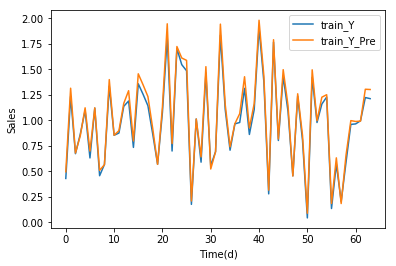

In [17]:
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as sess:
    # 变量初始化
    tf.global_variables_initializer().run()
    
    cost = []
    
    STEPS = 5000
    for i in range(STEPS):
        start = (i*Batch_Size) % M
        end = start + Batch_Size
        if end >= M:
            end = M
        
        _, tempLoss, w1 = sess.run([train_step, loss, W1], feed_dict={Place_X: train_X[:, start:end], Place_Y: train_Y[:, start:end]})
        cost.append(tempLoss)
        
        if i % 1000 == 0:
            print("After {} training step(s), Loss:{}; W1:{}".format(i, tempLoss, w1))
            
    # 获取预测结果
    train_Y_Pre = sess.run(Z1, feed_dict={Place_X: train_X, Place_Y: train_Y})
    
    # 显示Loss
    plt.plot(np.arange(M), train_Y[0, :], label='train_Y')
    plt.plot(np.arange(M), train_Y_Pre[0, :], label='train_Y_Pre')
    plt.xlabel("Time(d)")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

## 其他思考

我们还可以做一个对比试验: 我们把 `MSE` 作为损失函数. 最终预测的结果会很贴近真实值。但是贴近真实值并不意味着模型最优，因为它并不能使得商家的利润最大化，成本最小。所以损失函数要和具体应用场景相关。